<a href="https://colab.research.google.com/github/MoqiSheng/MoqiSheng.github.io/blob/main/LSTMPredict%E2%80%94%E2%80%940422.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data...
Training data preview:
          日期        开盘        最高        最低        收盘    成交量        成交额  \
0 2019-01-29  27397.54  27575.37  27328.17  27531.68   8659   86589.93   
1 2019-01-30  27571.41  27642.85  27369.75  27642.85   8881   88808.08   
2 2019-01-31  27842.05  28010.90  27773.98  27942.47  11315  113154.02   
3 2019-02-01  28193.28  28193.28  27802.50  27930.74   8549   85486.16   
4 2019-02-04  27985.42  28005.15  27847.43  27990.21   3815   38149.45   

     下一次收盘价       滞后1       滞后2       滞后3        MA5        MA20        RSI  
0  27642.85  27576.96  27569.19  27120.98  27361.402  26603.4535  78.162119  
1  27942.47  27531.68  27576.96  27569.19  27488.332  26729.0785  79.390042  
2  27930.74  27642.85  27531.68  27576.96  27652.630  26872.9840  82.281722  
3  27990.21  27942.47  27642.85  27531.68  27724.940  26988.2195  81.797854  
4  27946.32  27930.74  27942.47  27642.85  27807.590  27095.9450  82.364101  

Training data shape: (822, 14)

Validation data

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5616 - val_loss: 0.1107
Epoch 2/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1042 - val_loss: 0.0589
Epoch 3/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1104 - val_loss: 0.0494
Epoch 4/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0942 - val_loss: 0.0327
Epoch 5/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0810 - val_loss: 0.0329
Epoch 6/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0752 - val_loss: 0.0311
Epoch 7/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0808 - val_loss: 0.0300
Epoch 8/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0746 - val_loss: 0.0286
Epoch 9/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0729 - val_loss: 0.0296
Epoch 10/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0660 - val_loss: 0.0282
Epoch 11/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0682 - val_loss: 0.0312
Epoch 12/150
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0747 - val_l

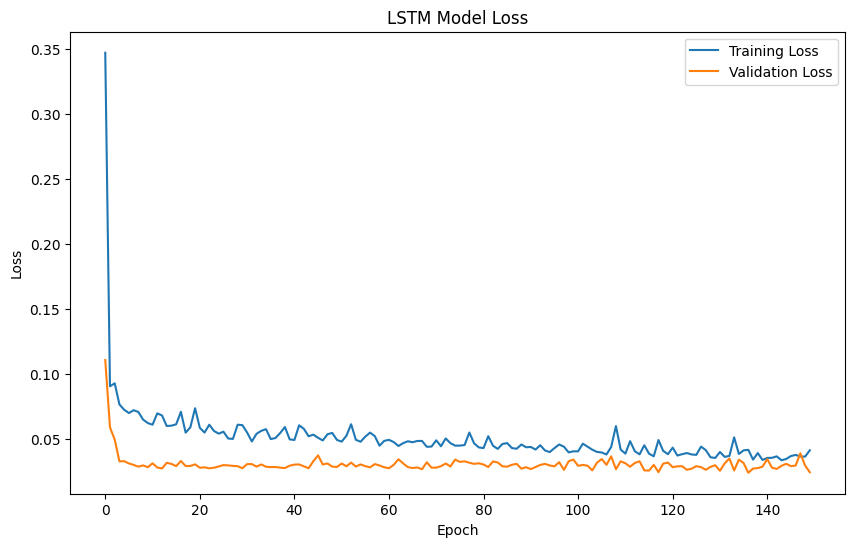


Making predictions...
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Calculating performance metrics...
MSE: 242728.8220
RMSE: 492.6752
MAE: 415.7194
MAPE: 2.2889%


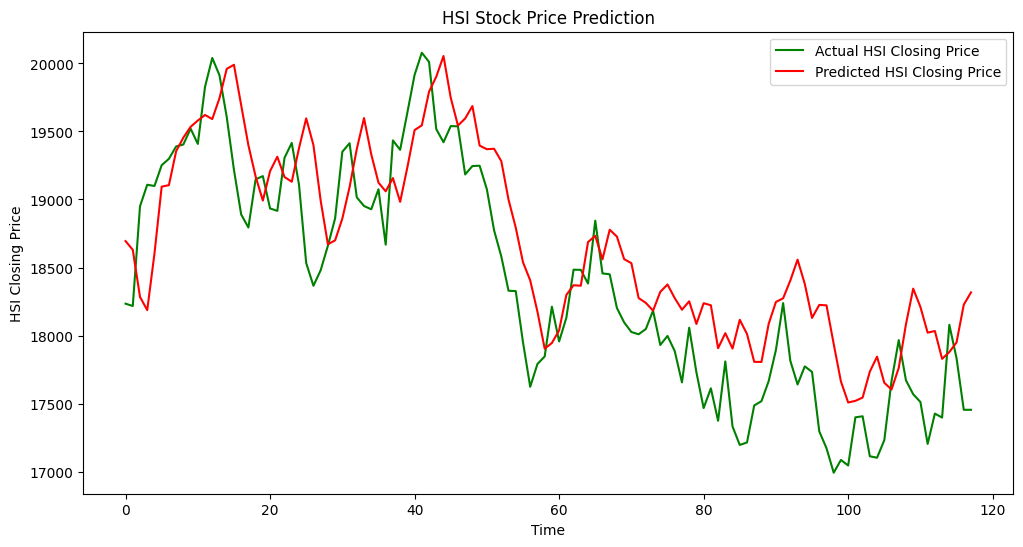


Results saved to 'HSI_prediction_results.xlsx'


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt

# Function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Load data
print("Loading data...")
train_data = pd.read_excel('HSI_日线_LSTM_train.xlsx')
val_data = pd.read_excel('HSI_日线_LSTM_val.xlsx')
test_data = pd.read_excel('HSI_日线_LSTM_test.xlsx')

# Display the first few rows to understand the data structure
print("Training data preview:")
print(train_data.head())
print("\nTraining data shape:", train_data.shape)
print("\nValidation data shape:", val_data.shape)
print("\nTest data shape:", test_data.shape)

# Combine training and validation datasets for model training
combined_train_data = pd.concat([train_data, val_data], axis=0)
print("\nCombined training data shape:", combined_train_data.shape)

# Select features and target
feature_columns = ['开盘', '最高', '最低', '收盘', '成交量', '成交额',
                   '滞后1', '滞后2', '滞后3', 'MA5', 'MA20', 'RSI']
target_column = '下一次收盘价'

# Prepare data for LSTM
def prepare_data_for_lstm(data, feature_cols, target_col, time_steps=3):
    # Scale the data
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    # Fit scalers on training data only
    features_scaled = scaler_features.fit_transform(data[feature_cols])
    targets_scaled = scaler_target.fit_transform(data[[target_col]])

    X, y = [], []

    # Create sequences
    for i in range(len(data) - time_steps):
        X.append(features_scaled[i:i+time_steps])
        y.append(targets_scaled[i+time_steps])

    return np.array(X), np.array(y), scaler_features, scaler_target

# Set time steps (lookback period)
time_steps = 3

# Prepare combined training data
X_train, y_train, scaler_features, scaler_target = prepare_data_for_lstm(
    combined_train_data, feature_columns, target_column, time_steps)

# Prepare test data using the same scalers
test_features_scaled = scaler_features.transform(test_data[feature_columns])
test_targets_scaled = scaler_target.transform(test_data[[target_column]])

X_test, y_test = [], []
for i in range(len(test_data) - time_steps):
    X_test.append(test_features_scaled[i:i+time_steps])
    y_test.append(test_targets_scaled[i+time_steps])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("\nTraining data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    return model

# Build and train the model
print("\nBuilding and training the LSTM model...")
model = build_lstm_model((time_steps, len(feature_columns)))
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    shuffle=False
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('lstm_training_history.png')
plt.show()

# Make predictions
print("\nMaking predictions...")
predicted_scaled = model.predict(X_test)

# Inverse transform to get actual values
# Create a placeholder array for inverse transformation
predicted_placeholder = np.zeros((len(predicted_scaled), 1))
predicted_placeholder[:, 0] = predicted_scaled[:, 0]

# Inverse transform
predicted_actual = scaler_target.inverse_transform(predicted_placeholder)
actual_values = scaler_target.inverse_transform(y_test)

# Calculate performance metrics
print("\nCalculating performance metrics...")
mse = mean_squared_error(actual_values, predicted_actual)
rmse = sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_actual)
mape = mean_absolute_percentage_error(actual_values, predicted_actual)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, color='green', label='Actual HSI Closing Price')
plt.plot(predicted_actual, color='red', label='Predicted HSI Closing Price')
plt.title('HSI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('HSI Closing Price')
plt.legend()
plt.savefig('lstm_prediction_results.png')
plt.show()

# Save predictions to Excel
results_df = pd.DataFrame()
results_df['Actual'] = actual_values.flatten()
results_df['Predicted'] = predicted_actual.flatten()
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
results_df['Abs_Error'] = abs(results_df['Error'])
results_df['Percentage_Error'] = abs(results_df['Error'] / results_df['Actual']) * 100

# Get original dates for reference
dates = test_data.iloc[time_steps:len(predicted_actual) + time_steps]['日期'].reset_index(drop=True)
results_df['Date'] = dates

# Reorder columns
results_df = results_df[['Date', 'Actual', 'Predicted', 'Error', 'Abs_Error', 'Percentage_Error']]

results_df.to_excel('HSI_prediction_results.xlsx', index=False)
print("\nResults saved to 'HSI_prediction_results.xlsx'")